In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly 
import plotly.express as px
import plotly.graph_objects as go
import random
import time
import cv2 
import os 
import asdf 
import pickle
import csv
import scipy
from scipy import signal 
from scipy.stats import pearsonr,spearmanr,sem
from motion_analysis_functions import calc_norm_spec,mean_freq_ratio,split_by_0

In [2]:
###---INPUT---###
folder = '/Users/Documents/...'
experiment = 'SquareOF'
animals_list_updated = ['DAT_Casp3', 'Anxa1_TeLC', 'MitoPark'] 
sub_fold=[name for name in os.listdir(folder) if experiment in name]

# Threshold:
low_f=12; high_f=18 
low_f_imob=10 ; high_f_imob=15

# make folders for outputs
output=os.path.join(folder,'outputs') 
processed_data=os.path.join(output,'processed_data')
final_output=os.path.join(folder,'outputs/final_output')
os.makedirs(output, exist_ok=True)
os.makedirs(processed_data, exist_ok=True)
os.makedirs(final_output, exist_ok = True)

##---Read the unpreprocessed pkl data for making final pkl data---##
pkldata=[];data=[]; df=[]
for i in range(len(animals_list_updated)):
    pkldata.append('df_unprocessed_' + animals_list_updated[i] + '_for_analysis_' + experiment + '.pkl') # animals_list_updated
    data.append(open(os.path.join(processed_data, pkldata[i]),'rb'))
    df.append(pickle.load(data[i]))

In [3]:
for i in range(len(animals_list_updated)):
    
    ###---Basic analysis---###
    x_body_accel=[]; y_body_accel=[]; z_body_accel=[];
    x_freq_all=[]; x_ratio_f=[]; f_all=[]; T_accel=[]; 

    cutoff=0.1
    edges=np.linspace(-7,2,100) 
    bin_center=(np.diff(edges)/2)+edges[0:-1] 
    wind=30 
    mask=np.ones((1,wind))/wind
    mask=mask[0,:] 

    for ind,session in df[i].iterrows():
        fs = session.acc_freq  
        fc = 1  
        w = fc / (fs / 2) 
        b, a = signal.butter(5, w, 'low')
        BaccelX=session.AccelX-signal.filtfilt(b, a, session.AccelX) 
        BaccelY=session.AccelY-signal.filtfilt(b, a, session.AccelY)
        BaccelZ=session.AccelZ-signal.filtfilt(b, a, session.AccelZ)
        Total=np.sqrt(BaccelX**2+BaccelY**2+BaccelZ**2)
        X_freq_med, X_freq_norm, f=calc_norm_spec(BaccelX,fs) 
        ratio_X=np.median(X_freq_med[(f>low_f) & (f<high_f)])
        x_freq_all.append(X_freq_med)
        x_ratio_f.append(ratio_X)
        f_all.append(f)
        T_accel.append(Total)
        x_body_accel.append(BaccelX)
        y_body_accel.append(BaccelY)
        z_body_accel.append(BaccelZ)

    df[i]['X_freq_med']= x_freq_all; 
    df[i]['X_ratio_f']=x_ratio_f; 
    df[i]['f_bins']=f_all
    df[i]['BaccelX']= x_body_accel; df[i]['BaccelY']= y_body_accel; df[i]['BaccelZ']= z_body_accel
    df[i]['T_accel']=T_accel;
    df[i]['dist']=''; 

    ##---Immobile analysis---## 
    n=0; m=0
    x_freq_imob=[]; 
    x_ratio_f_imob=[]; 
    imobPowerX_Mat =[];
    x_imob_accel=[]; 

    for index,row in df[i].iterrows():
        body_accel=row.T_accel 
        body_accel=np.convolve(body_accel,mask,mode='same')
        [freq,bins]=np.histogram(np.log(body_accel),edges,density=True)
        df[i].at[index,'dist']=freq
        
        temp=[]
        for l in split_by_0(body_accel,cutoff,'below',30): 
            if len(l) >200:
                temp.extend(l)
        imob_accel=row.BaccelX[temp]
        if len(imob_accel) > 18000: 
            fs = row.acc_freq  
            imob_X_freq_med, imob_X_freq_norm, f=calc_norm_spec(imob_accel,fs)  
            ratio_X_imob=np.median(imob_X_freq_med[(f>low_f_imob) & (f<high_f_imob)]) 
        else:
            imob_X_freq_med=np.empty(f.shape)
            imob_X_freq_med[:]= np.nan
            ratio_X_imob=np.nan
        x_freq_imob.append(imob_X_freq_med)
        x_ratio_f_imob.append(ratio_X_imob)
        imobPowerX_Mat.append(imob_X_freq_norm)
        x_imob_accel.append(imob_accel)    

    df[i]['X_freq_imob']= x_freq_imob;
    df[i]['X_ratio_f_imob']= x_ratio_f_imob; 
    df[i]['imobPowerX_Mat']= imobPowerX_Mat; 
    df[i]['x_imob_accel']= x_imob_accel; 

    wind1=60; wind2=60 
    init_all=[]
    bouts_all=[]
    mean_accel=[]
    total_accel=[]
    imob_time=[]

    for index,row in df[i].iterrows():
        try:    
            body_accel=row.T_accel
            body_accel=np.convolve(body_accel,mask,mode='same')
            mob_accel=body_accel>cutoff
            imob_accel=body_accel<=cutoff
            transitions=np.diff(mob_accel.astype(int))
            inits= np.where(transitions == 1)[0]
            total_accel.append(body_accel) 
            imob_time.append(len(body_accel[(body_accel<=cutoff)])/len(body_accel)*100) 

            n=0
            bouts=[]
            for init in inits:
                if np.sum(mob_accel[init+1-wind1:init+1])==0 and np.sum(mob_accel[init+1:init+1+wind2])==wind2:
                    n+=1
                    temp=np.diff(mob_accel[init:].astype(int))
                    stop= np.where(temp == -1)[0]
                    if len(stop)>0:
                        bouts.append(stop[0])
        except:
            n=np.nan
            bouts=np.nan
            total_accel.append(np.nan)
            imob_time.append(np.nan)

        init_all.append(n/(len(body_accel)/12000)) 
        bouts_all.append(np.nanmedian(bouts)/200)
        mean_accel.append(np.nanmean(body_accel))

    df[i]['Init_number']=init_all
    df[i]['bout_time']=bouts_all
    df[i]['body_accel']=total_accel
    df[i]['Perc_immobile']= imob_time
    df[i].to_pickle(os.path.join(processed_data + '/' + 'df_' + animals_list_updated[i] + '.pkl'))

In [4]:
# Read the pkl data 
pkldata = []
data = []
df_all = []
for i in range(len(animals_list_updated)):
    pkldata.append('df_' + animals_list_updated[i] + '.pkl')
for k in range(len(pkldata)):
    data.append(open(os.path.join(processed_data, pkldata[k]),'rb'))
    df_all.append(pickle.load(data[k]))
pkldata

['df_DAT_Casp3.pkl', 'df_Anxa1_TeLC.pkl', 'df_MitoPark.pkl']

In [5]:
# dataframe for animals
dat_casp3 = df_all[0][(df_all[0]['Group'] =='Casp3')] 
dat_ctrl = df_all[0][(df_all[0]['Group']=='Control')]
anxa1_telc = df_all[1][(df_all[1]['Group']=='TeLC')]
anxa1_ctrl = df_all[1][(df_all[1]['Group']=='Control')] 
mitopark = df_all[2][(df_all[2]['Key']=='MitoPark')]
mitopark_ctrl = df_all[2][(df_all[2]['Key']=='Control')]

f = df_all[0].f_bins[1] # pick up one frequency
fhz = df_all[2].acc_freq[42] # 200Hz

mitopark8 = mitopark[(mitopark['Weeks']==8)]
mitopark_ctrl8 = mitopark_ctrl[(mitopark_ctrl['Weeks']==8)]
mitopark16 = mitopark[(mitopark['Weeks']==16)]
mitopark_ctrl16 = mitopark_ctrl[(mitopark_ctrl['Weeks']==16)]
mitopark24 = mitopark[(mitopark['Weeks']==24)]
mitopark_ctrl24 = mitopark_ctrl[(mitopark_ctrl['Weeks']==24)]

R-squared r1^2: 0.78
R-squared r2^2: 0.04
R-squared r3^2: 0.60
R-squared r4^2: 0.21


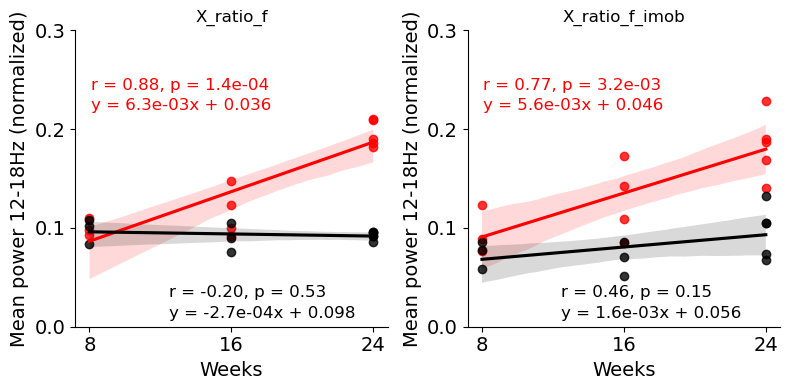

In [6]:
# Calculate correlation coefficient
corr_coef1, p_value1 = pearsonr(mitopark.Weeks[~np.isnan(mitopark.X_ratio_f)],mitopark.X_ratio_f[~np.isnan(mitopark.X_ratio_f)])
corr_coef2, p_value2 = pearsonr(mitopark_ctrl.Weeks[~np.isnan(mitopark_ctrl.X_ratio_f)],mitopark_ctrl.X_ratio_f[~np.isnan(mitopark_ctrl.X_ratio_f)])
corr_coef3, p_value3 = pearsonr(mitopark.Weeks[~np.isnan(mitopark.X_ratio_f_imob)], mitopark.X_ratio_f_imob[~np.isnan(mitopark.X_ratio_f_imob)]) 
corr_coef4, p_value4 = pearsonr(mitopark_ctrl.Weeks[~np.isnan(mitopark_ctrl.X_ratio_f_imob)], mitopark_ctrl.X_ratio_f_imob[~np.isnan(mitopark_ctrl.X_ratio_f_imob)])

xticks_min = min(pd.concat([mitopark['days'], mitopark_ctrl['days']]))
xticks_max = max(pd.concat([mitopark['days'], mitopark_ctrl['days']]))

fig,axs = plt.subplots(1,2,figsize = (8,4))

p1 = sns.regplot(x = mitopark.Weeks[~np.isnan(mitopark.X_ratio_f)], y = mitopark.X_ratio_f[~np.isnan(mitopark.X_ratio_f)], ax = axs[0], color = 'r')
slope1, intercept1, r1, p1, sterr1 = scipy.stats.linregress(x = mitopark.Weeks[~np.isnan(mitopark.X_ratio_f)], y = mitopark.X_ratio_f[~np.isnan(mitopark.X_ratio_f)])
p2 = sns.regplot(x = mitopark_ctrl.Weeks[~np.isnan(mitopark_ctrl.X_ratio_f)], y = mitopark_ctrl.X_ratio_f[~np.isnan(mitopark_ctrl.X_ratio_f)], ax = axs[0], color = 'k')
slope2, intercept2, r2, p2, sterr2 = scipy.stats.linregress(x = mitopark_ctrl.Weeks[~np.isnan(mitopark_ctrl.X_ratio_f)], y = mitopark_ctrl.X_ratio_f[~np.isnan(mitopark_ctrl.X_ratio_f)])
print(f"R-squared r1^2: {r1**2:.2f}")
print(f"R-squared r2^2: {r2**2:.2f}")

axs[0].set_title('X_ratio_f')
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].set_xlabel('Weeks', fontsize = 14)
axs[0].set_ylabel('Mean power 12-18Hz (normalized)', fontsize = 14)
axs[0].set_xticks([8,16,24])
axs[0].set_yticks(np.arange(0,0.35,0.1))
axs[0].tick_params(axis = 'both', labelsize = 14)
axs[0].text(.05, .80, 'r = {:.2f}'.format(corr_coef1) + ', p = ' + "{:.1e}".format(p_value1), transform = axs[0].transAxes, fontsize = 12, color = 'r') 
axs[0].text(.05, .73, 'y = ' + "{:.1e}".format(slope1) + 'x'  + ' + ' +  str(round(intercept1,3)), transform = axs[0].transAxes, fontsize = 12, color = 'r')
axs[0].text(.30, .10, 'r = {:.2f}'.format(corr_coef2) + ', p = ' + '{:.2f}'.format(p_value2), transform = axs[0].transAxes, fontsize = 12, color = 'k') 
axs[0].text(.30, .03, 'y = ' + "{:.1e}".format(slope2) + 'x'  + ' + ' +  str(round(intercept2,3)), transform = axs[0].transAxes, fontsize = 12, color = 'k')

p3 = sns.regplot(x = mitopark.Weeks[~np.isnan(mitopark.X_ratio_f_imob)], y = mitopark.X_ratio_f_imob[~np.isnan(mitopark.X_ratio_f_imob)], ax = axs[1], color = 'r')
slope3, intercept3, r3, p3, sterr3 = scipy.stats.linregress(x = mitopark.Weeks[~np.isnan(mitopark.X_ratio_f_imob)], y = mitopark.X_ratio_f_imob[~np.isnan(mitopark.X_ratio_f_imob)])
p4 = sns.regplot(x = mitopark_ctrl.Weeks[~np.isnan(mitopark_ctrl.X_ratio_f_imob)], y = mitopark_ctrl.X_ratio_f_imob[~np.isnan(mitopark_ctrl.X_ratio_f_imob)], ax = axs[1], color = 'k')
slope4, intercept4, r4, p4, sterr4 = scipy.stats.linregress(x = mitopark_ctrl.Weeks[~np.isnan(mitopark_ctrl.X_ratio_f_imob)], y = mitopark_ctrl.X_ratio_f_imob[~np.isnan(mitopark_ctrl.X_ratio_f_imob)])
print(f"R-squared r3^2: {r3**2:.2f}")
print(f"R-squared r4^2: {r4**2:.2f}")

axs[1].set_title('X_ratio_f_imob')
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].set_xlabel('Weeks', fontsize = 14)
axs[1].set_ylabel('Mean power 12-18Hz (normalized)', fontsize = 14)
axs[1].set_xticks([8,16,24])
axs[1].set_yticks(np.arange(0,0.35,0.1))
axs[1].tick_params(axis = 'both', labelsize = 14)
axs[1].text(.05, .80, 'r = {:.2f}'.format(corr_coef3) + ', p = ' + "{:.1e}".format(p_value3), transform = axs[1].transAxes, fontsize = 12, color = 'r') 
axs[1].text(.05, .73, 'y = ' + "{:.1e}".format(slope3) + 'x'  + ' + ' +  str(round(intercept3,3)), transform = axs[1].transAxes, fontsize = 12, color = 'r')
axs[1].text(.30, .10, 'r = {:.2f}'.format(corr_coef4) + ', p = ' + '{:.2f}'.format(p_value4), transform = axs[1].transAxes, fontsize = 12, color = 'k') 
axs[1].text(.30, .03, 'y = ' + "{:.1e}".format(slope4) + 'x'  + ' + ' +  str(round(intercept4,3)), transform = axs[1].transAxes, fontsize = 12, color = 'k')

fig.tight_layout()
fig.savefig(os.path.join(final_output, 'Mean_power_vs_Weeks_only_8_16_24wks_' + '.pdf'))
fig.savefig(os.path.join(final_output, 'Mean_power_vs_Weeks_only_8_16_24wks_' + '.png'))

with open(os.path.join(final_output,'Statistics_MitoPark_mice_frequency.csv'), 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(['Animals','Type', 'Pearsons correlation coefficient', '2-tailed p-value','n_animals_8wks','n_animals_16wks','n_animals_24wks'])
    writer.writerow(['MitoPark mice','Frequency_ratio_total', corr_coef1, p_value1, len(mitopark[(mitopark['Weeks'] == 8)]), len(mitopark[(mitopark['Weeks'] == 16)]), len(mitopark[(mitopark['Weeks'] == 24)])])
    writer.writerow(['MitoPark mice','Frequency_ratio_imob', corr_coef3, p_value3, len(mitopark[(mitopark['Weeks'] == 8)]), len(mitopark[(mitopark['Weeks'] == 16)]), len(mitopark[(mitopark['Weeks'] == 24)])])
    writer.writerow(['Littermate controls','Frequency_ratio_total', corr_coef2, p_value2, len(mitopark_ctrl[(mitopark_ctrl['Weeks'] == 8)]), len(mitopark_ctrl[(mitopark_ctrl['Weeks'] == 16)]), len(mitopark_ctrl[(mitopark_ctrl['Weeks'] == 24)])])
    writer.writerow(['Littermate controls','Frequency_ratio_imob', corr_coef4, p_value4, len(mitopark_ctrl[(mitopark_ctrl['Weeks'] == 8)]), len(mitopark_ctrl[(mitopark_ctrl['Weeks'] == 16)]), len(mitopark_ctrl[(mitopark_ctrl['Weeks'] == 24)])])

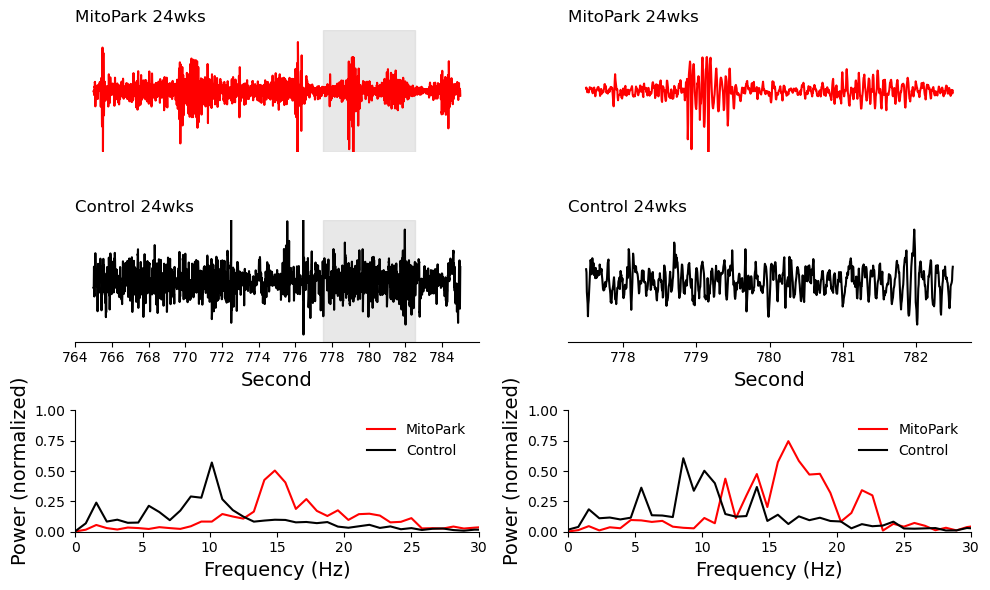

In [7]:
data_range_long = range(153000,157000,1)
data_range_short = range(155500,156500,1)

X_freq_med_mitopark_long, X_freq_norm_mitopark_long, f_long = calc_norm_spec(df_all[2].AccelX[54][data_range_long],fhz) # No.54 MitoPark 24wks 
X_freq_med_mitopark_ctrl_long, X_freq_norm_mitopark_ctrl_long, f_long = calc_norm_spec(df_all[2].AccelX[53][data_range_long],fhz) # No.53 Control 24wks
X_freq_med_mitopark_short, X_freq_norm_mitopark_short, f_short = calc_norm_spec(df_all[2].AccelX[54][data_range_short],fhz) # No.54 MitoPark 24wks 
X_freq_med_mitopark_ctrl_short, X_freq_norm_mitopark_ctrl_short, f_short = calc_norm_spec(df_all[2].AccelX[53][data_range_short],fhz) # No.53 Control 24wks

fig,axs = plt.subplots(3,2,figsize = (10,6))
axs[0,0].plot(data_range_long/fhz, df_all[2].AccelX[54][data_range_long], 'r') # converted to second
axs[0,0].set_ylim([-0.8, 0.8])
axs[0,0].set_title('MitoPark 24wks', loc = 'left')
axs[0,0].axis('off')
axs[0,0].axvspan(data_range_short[0]/fhz, (data_range_short[-1]+1)/fhz, color = 'lightgray', alpha = 0.5) # pick up short range area
axs[1,0].plot(data_range_long/fhz, df_all[2].AccelX[53][data_range_long], 'k') 
axs[1,0].set_ylim([-0.8, 0.8])
axs[1,0].set_title('Control 24wks', loc = 'left')
axs[1,0].set_yticks([])
axs[1,0].spines[['right', 'left', 'top']].set_visible(False)
axs[1,0].axvspan(data_range_short[0]/fhz, (data_range_short[-1]+1)/fhz, color = 'lightgray', alpha = 0.5) # pick up short range area
start, end = axs[1,0].get_xlim()
axs[1,0].set_xticks(np.arange(round(start), round(end), 2.0))
axs[1,0].set_xlabel('Second', fontsize = 14)
axs[2,0].plot(f_long,X_freq_med_mitopark_long, 'r')
axs[2,0].plot(f_long,X_freq_med_mitopark_ctrl_long, 'k')
axs[2,0].set_xlim([0,30])
axs[2,0].set_ylim([0.0,1.0])
axs[2,0].spines[['right', 'top']].set_visible(False)
axs[2,0].set_xlabel('Frequency (Hz)', fontsize = 14)
axs[2,0].set_ylabel('Power (normalized)', fontsize = 14)
axs[2,0].legend(['MitoPark', 'Control'], frameon = False)

axs[0,1].plot(data_range_short/fhz, df_all[2].AccelX[54][data_range_short], 'r') 
axs[0,1].set_ylim([-0.8, 0.8])
axs[0,1].set_title('MitoPark 24wks', loc = 'left')
axs[0,1].axis('off')
axs[1,1].plot(data_range_short/fhz, df_all[2].AccelX[53][data_range_short], 'k') 
axs[1,1].set_ylim([-0.8, 0.8])
axs[1,1].set_title('Control 24wks', loc = 'left')
axs[1,1].set_yticks([])
axs[1,1].spines[['right', 'left', 'top']].set_visible(False)
axs[1,1].set_xlabel('Second', fontsize = 14)
axs[2,1].plot(f_short,X_freq_med_mitopark_short, 'r')
axs[2,1].plot(f_short,X_freq_med_mitopark_ctrl_short, 'k')
axs[2,1].set_xlim([0,30])
axs[2,1].set_ylim([0.0,1.0])
axs[2,1].spines[['right', 'top']].set_visible(False)
axs[2,1].set_xlabel('Frequency (Hz)', fontsize = 14)
axs[2,1].set_ylabel('Power (normalized)', fontsize = 14)
axs[2,1].legend(['MitoPark', 'Control'], frameon = False)

fig.tight_layout()
fig.savefig(os.path.join(final_output, 'Tremor_example_figure_of_MitoPark_24wks.pdf'))
fig.savefig(os.path.join(final_output, 'Tremor_example_figure_of_MitoPark_24wks.png'))

In [8]:
# Combine data of virus injection animals with MitoPark data
combined_list = [mitopark8, mitopark16, mitopark24] + [dat_casp3, anxa1_telc]
combined_ctrl_list = [mitopark_ctrl8, mitopark_ctrl16, mitopark_ctrl24] + [dat_ctrl, anxa1_ctrl]
animal_list = ['8wks', '16wks', '24wks'] + ['DAT-Casp3', 'Anxa1-TeLC']

combined_list_freq = []; combined_list_freq_imob = []
combined_ctrl_list_freq = []; combined_ctrl_list_freq_imob = []
combined_list_ratio_f = []; combined_list_ratio_f_imob = []
combined_ctrl_list_ratio_f = []; combined_ctrl_list_ratio_f_imob = []

for i in range(len(combined_list)):
    combined_list_freq.append(np.nanmean(np.vstack(combined_list[i]['X_freq_med']),axis = 0))
    combined_list_freq_imob.append(np.nanmean(np.vstack(combined_list[i]['X_freq_imob']),axis = 0))
    combined_ctrl_list_freq.append(np.nanmean(np.vstack(combined_ctrl_list[i]['X_freq_med']),axis = 0))
    combined_ctrl_list_freq_imob.append(np.nanmean(np.vstack(combined_ctrl_list[i]['X_freq_imob']),axis = 0))
    
    combined_list_ratio_f.append(np.nanmean(np.vstack(combined_list[i]['X_ratio_f']),axis = 0))
    combined_list_ratio_f_imob.append(np.nanmean(np.vstack(combined_list[i]['X_ratio_f_imob']),axis = 0))
    combined_ctrl_list_ratio_f.append(np.nanmean(np.vstack(combined_ctrl_list[i]['X_ratio_f']),axis = 0))
    combined_ctrl_list_ratio_f_imob.append(np.nanmean(np.vstack(combined_ctrl_list[i]['X_ratio_f_imob']),axis = 0))

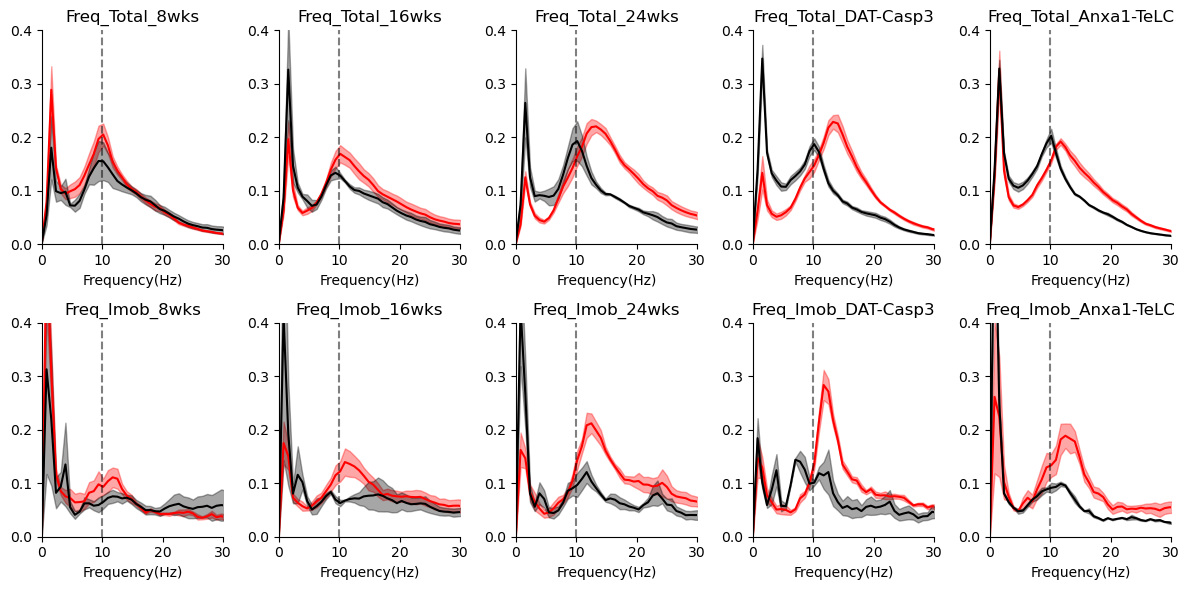

In [9]:
# final_output
fig, axs = plt.subplots(2,5,figsize = (12,6))

for i in range(len(combined_list)):
    axs[0,i].plot(f,combined_list_freq[i], color = 'red')
    axs[0,i].plot(f,combined_ctrl_list_freq[i], color = 'black')
    axs[0,i].fill_between(f, combined_list_freq[i] - sem(np.vstack(combined_list[i]['X_freq_med']), nan_policy = 'omit'), combined_list_freq[i] + sem(np.vstack(combined_list[i]['X_freq_med']), nan_policy = 'omit'), color = 'red', alpha = 0.35)
    axs[0,i].fill_between(f, combined_ctrl_list_freq[i] - sem(np.vstack(combined_ctrl_list[i]['X_freq_med']), nan_policy = 'omit'), combined_ctrl_list_freq[i] + sem(np.vstack(combined_ctrl_list[i]['X_freq_med']), nan_policy = 'omit'), color = 'black', alpha = 0.35)
    axs[0,i].set_xlabel('Frequency(Hz)')
    axs[0,i].axvline(x = 10, color = 'black', alpha = 0.5, linestyle = '--')
    axs[0,i].spines[['right', 'top']].set_visible(False)
    axs[0,i].set_ylim(0, 0.4)
    axs[0,i].set_xlim(0, 30)
    axs[0,i].set_title('Freq_Total_' + animal_list[i])

    axs[1,i].plot(f,combined_list_freq_imob[i], color = 'red')
    axs[1,i].plot(f,combined_ctrl_list_freq_imob[i], color = 'black')
    axs[1,i].fill_between(f, combined_list_freq_imob[i] - sem(np.vstack(combined_list[i]['X_freq_imob']), nan_policy = 'omit'), combined_list_freq_imob[i] + sem(np.vstack(combined_list[i]['X_freq_imob']), nan_policy = 'omit'), color = 'red', alpha = 0.35)
    axs[1,i].fill_between(f, combined_ctrl_list_freq_imob[i] - sem(np.vstack(combined_ctrl_list[i]['X_freq_imob']), nan_policy = 'omit'), combined_ctrl_list_freq_imob[i] + sem(np.vstack(combined_ctrl_list[i]['X_freq_imob']), nan_policy = 'omit'), color = 'black', alpha = 0.35)
    axs[1,i].set_xlabel('Frequency(Hz)')
    axs[1,i].axvline(x = 10, color = 'black', alpha = 0.5, linestyle = '--')
    axs[1,i].spines[['right', 'top']].set_visible(False)
    axs[1,i].set_ylim(0, 0.4)
    axs[1,i].set_xlim(0, 30)
    axs[1,i].set_title('Freq_Imob_' + animal_list[i])    
    
fig.tight_layout()
fig.savefig(os.path.join(final_output, 'MitoPark_DAT_Anxa1_all_freq_data_' + '.pdf'), bbox_inches = 'tight', dpi = 300)
fig.savefig(os.path.join(final_output, 'MitoPark_DAT_Anxa1_all_freq_data_' + '.png'), bbox_inches = 'tight', dpi = 300)